## Background

v1.1(Time-split) 분석에서 **Consistency(방문 리듬/규칙성)** 가 60–180 구간 성과와 강하게 연관되는 패턴을 확인했다.  
다만 관찰 분석의 한계를 보완하기 위해, **신규 유입 코호트(베이스라인과 분리)** 로 **2×2 factorial A/B Test(Activation uplift × Consistency uplift)** 를 구성했다.  
본 노트북은 **BigQuery DM(ecommerce_dm_ab.AB_user_kpi)에서 export한 CSV** 를 기반으로 **main effects 및 bootstrap CI** 로 효과를 추정한다.


## Load dataset (AB_user_kpi export)
**Goal:** BigQuery DM(`AB_user_kpi`)에서 export한 CSV를 로드  
**Output check:** 데이터셋 로드 

In [1]:
import pandas as pd
import numpy as np

FILE_PATH = "dm_ab_dataset.csv"  

df = pd.read_csv(FILE_PATH)

df.head()

,user_id,signup_date,exp_cell,has_order_0_13,orders_0_13,active_days_0_60,gap_cv_0_60,gap_cnt_0_60,revenue_60_180,orders_60_180,has_purchase_60_180
0,UA_000001,2025-01-07,TC,False,0,13,1.472569,12.0,0.0,0,False
1,UA_000002,2025-01-07,CC,False,0,6,1.311747,5.0,0.0,0,False
2,UA_000003,2025-01-07,TC,False,0,3,1.157084,2.0,0.0,0,False
3,UA_000004,2025-01-07,TC,False,0,9,0.556183,8.0,0.0,0,False
4,UA_000005,2025-01-07,TC,False,0,6,1.325162,5.0,0.0,0,False


## Basic QA — cell split & schema
**Goal:** 2×2 factorial 랜덤할당이 의도대로 균등하게 들어갔는지 확인  
**Checks**
- exp_cell counts: CC/CT/TC/TT = 각 7,500씩 균등 분배 확인
- required columns 존재 여부 

In [2]:
# 컬럼 확인
print("cols:", df.columns.tolist())

# 기본 정합성: row/유저수
print("\nrows:", len(df))
print("distinct users:", df["user_id"].nunique())

# exp_cell 분포(25% 체크)
print("\nexp_cell counts:")
print(df["exp_cell"].value_counts())

df.head()

cols: ['user_id', 'signup_date', 'exp_cell', 'has_order_0_13', 'orders_0_13', 'active_days_0_60', 'gap_cv_0_60', 'gap_cnt_0_60', 'revenue_60_180', 'orders_60_180', 'has_purchase_60_180']

rows: 30000
distinct users: 30000

exp_cell counts:
TT    7500
CT    7500
TC    7500
CC    7500
Name: exp_cell, dtype: int64


,user_id,signup_date,exp_cell,has_order_0_13,orders_0_13,active_days_0_60,gap_cv_0_60,gap_cnt_0_60,revenue_60_180,orders_60_180,has_purchase_60_180
0,UA_000001,2025-01-07,TC,False,0,13,1.472569,12.0,0.0,0,False
1,UA_000002,2025-01-07,CC,False,0,6,1.311747,5.0,0.0,0,False
2,UA_000003,2025-01-07,TC,False,0,3,1.157084,2.0,0.0,0,False
3,UA_000004,2025-01-07,TC,False,0,9,0.556183,8.0,0.0,0,False
4,UA_000005,2025-01-07,TC,False,0,6,1.325162,5.0,0.0,0,False


## Cell-level summary table (CC/CT/TC/TT)

**Goal:** 2×2 factorial A/B의 각 셀(CC/CT/TC/TT) KPI를 한 표로 요약해, 이후 two-part/부트스트랩 분석의 기초통계 로 사용한다.

**What this does**
- **Cell split 확인:** 각 셀 유저 수가 균등(7,500명)인지 체크
- **Early(0–13d) activation 지표:** P(any order), avg orders
- **Consistency(0–60d) 행동 지표:** avg active_days, avg gap_cv
- **Long-term(60–180d) 성과 지표:** P(any purchase), avg orders, avg revenue, median revenue
- **Two-part용 보조:** 구매자만 대상으로 한 E[rev | buy] (buyer-only mean revenue)도 함께 계산해 표에 추가

> Note: median revenue = 0 은 **비구매자가 다수인 분포 특성**(zero-inflated)으로 자연스러운 결과이며, two-part에서 이를 분해해 해석한다.


In [3]:
# exp_cell split (분배 체크)
print("exp_cell counts:")
print(df["exp_cell"].value_counts().sort_index())

# cell-level summary table (전체 평균 기반)
cell_summary = (
    df.groupby("exp_cell")
      .agg(
          users=("user_id", "nunique"),
          # Early (0–13): Activation proxy
          p_any_order_0_13=("has_order_0_13", "mean"),
          avg_orders_0_13=("orders_0_13", "mean"),
          # Consistency (0–60)
          avg_active_days_0_60=("active_days_0_60", "mean"),
          avg_gap_cv_0_60=("gap_cv_0_60", "mean"),
          # Long-term (60–180)
          p_any_purchase_60_180=("has_purchase_60_180", "mean"),
          avg_orders_60_180=("orders_60_180", "mean"),
          avg_rev_60_180=("revenue_60_180", "mean"),
          med_rev_60_180=("revenue_60_180", "median"),
      )
      .sort_index()
)

# buyer-only mean revenue: E[rev | buy] (two-part용 보조 지표)
avg_rev_buyers_60_180 = (
    df.loc[df["has_purchase_60_180"] == 1]
      .groupby("exp_cell")["revenue_60_180"]
      .mean()
      .sort_index()
)

cell_summary["avg_rev_60_180_buyers"] = avg_rev_buyers_60_180

# output
#cell_summary

# -----------------------------
# Story screenshot table: only 핵심 컬럼 6 개만 
# -----------------------------
keep_cols = [
    "users",
    "p_any_order_0_13",
    "avg_gap_cv_0_60",
    "p_any_purchase_60_180",
    "avg_rev_60_180",
    "avg_rev_60_180_buyers",
]

tbl = cell_summary[keep_cols].copy()

# 확률/지표는 소수 4자리
four_dec = ["p_any_order_0_13", "avg_gap_cv_0_60", "p_any_purchase_60_180"]
tbl[four_dec] = tbl[four_dec].round(4)

# 매출은 정수 + 콤마(가독성)
rev_cols = ["avg_rev_60_180", "avg_rev_60_180_buyers"]
tbl[rev_cols] = tbl[rev_cols].round(0).astype("Int64")

display(
    tbl.style.format({
        "users": "{:,}",
        **{c: "{:.4f}" for c in four_dec},
        **{c: "{:,.0f}" for c in rev_cols},
    })
)



exp_cell counts:
CC    7500
CT    7500
TC    7500
TT    7500
Name: exp_cell, dtype: int64


,users,p_any_order_0_13,avg_gap_cv_0_60,p_any_purchase_60_180,avg_rev_60_180,avg_rev_60_180_buyers
exp_cell,,,,,,
CC,"7,500",0.0681,0.9793,0.2408,"77,428","321,545"
CT,"7,500",0.0613,0.9138,0.2608,"86,523","331,758"
TC,"7,500",0.0803,0.9744,0.2473,"83,855","339,035"
TT,"7,500",0.0800,0.9162,0.2633,"92,208","350,157"


### Part 1 — Purchase probability effects (60–180) + Early conversion check (0–13)

**Goal**  
2×2 factorial A/B에서 **구매 발생 확률(P(buy))**의 효과를 분해해  
- Activation main effect  
- Consistency main effect  
- Interaction (A×C)  
를 **difference-in-differences** 형태로 계산한다.

**Why we do this**
- Two-part의 첫 번째 구성요소인 **P(buy)**를 셀별로 확인하고, 실험 효과를 요약한다.
- 추가로 Early conversion(0–13d)을 함께 계산해, 장기(60–180)와 대비되는 “초기 전환(0–13)” 구간에서 Activation uplift의 방향성을 확인한다.

**Output**
- 60–180: P(buy) by cell + (Δp_A, Δp_C, Δp_interaction)
- 0–13: P(any order) by cell + (Δp0_A, Δp0_C, Δp0_interaction)


In [4]:
import numpy as np
import pandas as pd

# exp_cell -> factor(Activation/Consistency)로 풀기
df2 = df.copy()
df2["A"] = df2["exp_cell"].str[0]  # C/T (Activation)
df2["K"] = df2["exp_cell"].str[1]  # C/T (Consistency)
df2["A_treat"] = (df2["A"] == "T").astype(int)
df2["K_treat"] = (df2["K"] == "T").astype(int)
df2["AxK"] = df2["A_treat"] * df2["K_treat"]

# -----------------------------
# Part 1 Long-term purchase probability (60–180)
# -----------------------------
p_cell = df2.groupby("exp_cell")["has_purchase_60_180"].mean().sort_index()
print("Purchase rate by cell (60~180):")
print(p_cell.round(4))

# 2x2 main effects + interaction (difference-in-differences)
interaction_p = (p_cell["TT"] - p_cell["TC"]) - (p_cell["CT"] - p_cell["CC"])
main_A_p = ((p_cell["TC"] + p_cell["TT"]) / 2) - ((p_cell["CC"] + p_cell["CT"]) / 2)
main_K_p = ((p_cell["CT"] + p_cell["TT"]) / 2) - ((p_cell["CC"] + p_cell["TC"]) / 2)

print("\n=== Part 1 (Purchase probability) effects ===")
print("Activation main effect (Δp):", round(float(main_A_p), 4))
print("Consistency main effect (Δp):", round(float(main_K_p), 4))
print("Interaction (Δp):", round(float(interaction_p), 4))

# -----------------------------
# Early conversion (0–13): Activation contribution evidence
# -----------------------------
p0_cell = df2.groupby("exp_cell")["has_order_0_13"].mean().sort_index()
print("\nEarly order rate by cell (0~13):")
print(p0_cell.round(4))

interaction_p0 = (p0_cell["TT"] - p0_cell["TC"]) - (p0_cell["CT"] - p0_cell["CC"])
main_A_p0 = ((p0_cell["TC"] + p0_cell["TT"]) / 2) - ((p0_cell["CC"] + p0_cell["CT"]) / 2)
main_K_p0 = ((p0_cell["CT"] + p0_cell["TT"]) / 2) - ((p0_cell["CC"] + p0_cell["TC"]) / 2)

print("\n=== Early conversion effects (0–13) ===")
print("Activation main effect (Δp0):", round(float(main_A_p0), 4))
print("Consistency main effect (Δp0):", round(float(main_K_p0), 4))
print("Interaction (Δp0):", round(float(interaction_p0), 4))


Purchase rate by cell (60~180):
exp_cell
CC    0.2408
CT    0.2608
TC    0.2473
TT    0.2633
Name: has_purchase_60_180, dtype: float64

=== Part 1 (Purchase probability) effects ===
Activation main effect (Δp): 0.0045
Consistency main effect (Δp): 0.018
Interaction (Δp): -0.004

Early order rate by cell (0~13):
exp_cell
CC    0.0681
CT    0.0613
TC    0.0803
TT    0.0800
Name: has_order_0_13, dtype: float64

=== Early conversion effects (0–13) ===
Activation main effect (Δp0): 0.0154
Consistency main effect (Δp0): -0.0035
Interaction (Δp0): 0.0065


### Part 2 — Buyer conditional revenue (E[rev | buy], 60–180)

**Goal:** 구매 경험자(has_purchase_60_180=1)에 한정해 셀(CC/CT/TC/TT)별 60–180 누적매출 평균 **E[rev | buy]**를 계산하고, 2×2 요인(Activation/Consistency)의 **main effect + interaction(Δrev|buy)**를 추정한다.  
**Why:** 총 기대매출 E[rev]는 **구매확률 변화(P(buy))**와 **구매자당 매출 변화(E[rev|buy])**가 섞여 있다. Part 2는 구매확률을 고정한 채 **구매자당 매출(누적매출) 채널만** 분리해 해석한다.  
**Output:** (1) buyer-only mean revenue by cell, (2) Δrev|buy (A main / C main / interaction), (3) buyers n & buy rate


In [6]:
# -------------------------------------------------------
# Two-part combine: E[rev] = P(buy) * E[rev | buy]
# + lift decomposition (Part1 vs Part2 contribution)
# -------------------------------------------------------
# Part1: P(buy) by cell### 3.2 Part 2 — Buyer conditional revenue (E[rev | buy], 60–180)

p_cell = df2.groupby("exp_cell")["has_purchase_60_180"].mean().sort_index()

# Part2: E[rev|buy] by cell (already computed above as rev_b)
rev_b = df2.assign(
    rev_if_buy=np.where(df2["has_purchase_60_180"] == 1, df2["revenue_60_180"], np.nan)
).groupby("exp_cell")["rev_if_buy"].mean().sort_index()

# Two-part expected revenue
E_rev = (p_cell * rev_b).rename("E_rev_two_part")

print("P(buy):")
print(p_cell.round(4))
print("\nE[rev|buy]:")
print(rev_b.round(0).astype(int))
print("\nTwo-part E[rev] = P * E[rev|buy]:")
print(E_rev.round(0).astype(int))

# sanity
dm_avg = df2.groupby("exp_cell")["revenue_60_180"].mean().sort_index()
print("\nSanity check (two_part - avg_rev):")
print((E_rev - dm_avg).round(10))

# TT vs CC total lift (absolute, %)
lift_abs = float(E_rev["TT"] - E_rev["CC"])
lift_pct = float(E_rev["TT"] / E_rev["CC"] - 1)

print("\n(A) TT vs CC lift")
print("abs lift:", round(lift_abs, 2))
print("pct lift:", round(lift_pct, 4))

# (B) decomposition: keep one side fixed
p_CC, p_TT = float(p_cell["CC"]), float(p_cell["TT"])
r_CC, r_TT = float(rev_b["CC"]), float(rev_b["TT"])

part1_contrib = (p_TT - p_CC) * r_CC          # buy prob change, holding rev|buy at CC
part2_contrib = p_TT * (r_TT - r_CC)          # rev|buy change, using TT buy prob

print("\n(B) Contribution decomposition (TT vs CC)")
print("Part1 (P(buy)) contribution:", round(part1_contrib, 2))
print("Part2 (E[rev|buy]) contribution:", round(part2_contrib, 2))
print("Total:", round(part1_contrib + part2_contrib, 2), "==", round(lift_abs, 2))


P(buy):
exp_cell
CC    0.2408
CT    0.2608
TC    0.2473
TT    0.2633
Name: has_purchase_60_180, dtype: float64

E[rev|buy]:
exp_cell
CC    321545
CT    331758
TC    339035
TT    350157
Name: rev_if_buy, dtype: int32

Two-part E[rev] = P * E[rev|buy]:
exp_cell
CC    77428
CT    86523
TC    83855
TT    92208
Name: E_rev_two_part, dtype: int32

Sanity check (two_part - avg_rev):
exp_cell
CC    0.0
CT   -0.0
TC   -0.0
TT    0.0
dtype: float64

(A) TT vs CC lift
abs lift: 14780.0
pct lift: 0.1909

(B) Contribution decomposition (TT vs CC)
Part1 (P(buy)) contribution: 7245.49
Part2 (E[rev|buy]) contribution: 7534.51
Total: 14780.0 == 14780.0


### Two-part combine — E[rev] = P(buy) × E[rev | buy] + lift decomposition

**Goal**: Two-part로 셀별 기대매출 E[rev] 를 재구성하고(TT vs CC), total lift를 Part1(구매율) vs Part2(구매자 매출) 기여로 분해한다.  
**Why**: “총 기대매출 상승”이 *구매율 개선(Part 1)* 때문인지, *구매자당 매출 상승(Part 2)* 때문인지 분해하면 액션 우선순위(Activation vs Consistency)를 더 설득력 있게 제안할 수 있다.  
**Output**: (1) P(buy), E[rev|buy], E[rev] 테이블 (2) sanity check(two-part = DM avg) (3) TT vs CC lift (abs/%), (4) Part1/Part2 contribution


In [7]:
# -------------------------------------------------------
# Part 2 Buyer conditional revenue (60–180): E[rev | buy]
# -------------------------------------------------------
buyers = df2.loc[df2["has_purchase_60_180"] == 1].copy()

# buyer-only mean revenue by cell
rev_b = buyers.groupby("exp_cell")["revenue_60_180"].mean().sort_index()

print("Buyer-only mean revenue by cell (60–180):")
print(rev_b.round(0).astype(int))  # 원하면 round(1) 같은 걸로 바꿔도 됨

# 2x2 main effects + interaction (difference-in-differences) on E[rev|buy]
interaction_rev_b = (rev_b["TT"] - rev_b["TC"]) - (rev_b["CT"] - rev_b["CC"])
main_A_rev_b = ((rev_b["TC"] + rev_b["TT"]) / 2) - ((rev_b["CC"] + rev_b["CT"]) / 2)
main_K_rev_b = ((rev_b["CT"] + rev_b["TT"]) / 2) - ((rev_b["CC"] + rev_b["TC"]) / 2)

print("\n=== Part 2 (Buyer conditional revenue) effects ===")
print("Activation main effect (Δrev | buy):", round(float(main_A_rev_b), 0))
print("Consistency main effect (Δrev | buy):", round(float(main_K_rev_b), 0))
print("Interaction (Δrev | buy):", round(float(interaction_rev_b), 0))

buy_rate = len(buyers) / len(df2)
print("\nbuyers n:", len(buyers), "/ total:", len(df2), "/ buy rate:", round(buy_rate, 4))


Buyer-only mean revenue by cell (60–180):
exp_cell
CC    321545
CT    331758
TC    339035
TT    350157
Name: revenue_60_180, dtype: int32

=== Part 2 (Buyer conditional revenue) effects ===
Activation main effect (Δrev | buy): 17944.0
Consistency main effect (Δrev | buy): 10668.0
Interaction (Δrev | buy): 910.0

buyers n: 7592 / total: 30000 / buy rate: 0.2531


### Total 기대매출(60–180) 기준 2×2 메인효과 + 인터랙션(ΔE[rev])

**Goal**: 셀별 평균 revenue_60_180 (= zero 포함 평균, 곧 E[rev])을 기반으로 2×2 factorial의 **Activation/Consistency 메인효과**와 **AxK 인터랙션**을 한 번에 요약한다.  
**Why**: two-part 결과를 “최종 KPI(기대매출)” 관점에서도 같은 구조(메인효과/상호작용)로 정리하면 스토리텔링이 쉬워진다.  
**Output**:
- **TT vs CC lift(%)**
- Total KPI 기준 **Activation effect(ΔE[rev])**, **Consistency effect(ΔE[rev])**, **Interaction(ΔE[rev])**


In [9]:
means = df2.groupby("exp_cell")["revenue_60_180"].mean()
lift_TT_vs_CC = means["TT"]/means["CC"] - 1
print("TT vs CC lift:", lift_TT_vs_CC)

# Main effects on total revenue (2x2 factorial)
act = means["TC"] - means["CC"]
con = means["CT"] - means["CC"]
inter = (means["TT"] - means["TC"]) - (means["CT"] - means["CC"])
print("Activation effect (total):", act)
print("Consistency effect (total):", con)
print("Interaction (total):", inter)


TT vs CC lift: 0.1908866889037748
Activation effect (total): 6426.53333333334
Consistency effect (total): 9094.400000000009
Interaction (total): -740.9333333333489


###  Bootstrap CI로 Consistency uplift 불확실성 정량화 (two-part + total)

**Goal**: Consistency 메인효과가 “우연 변동”이 아닌지 확인하기 위해, 부트스트랩으로 95% 신뢰구간(CI)을 추정한다.  
**Why**: A/B 결과를 단순 평균 비교로 끝내지 않고, **효과의 불확실성(variance)**까지 함께 제시하면 실무적인 신뢰도가 올라간다.  
**What we bootstrap (B=3000)**:
1) **Part 1**: 장기 구매확률 P(buy) (60–180)에서 Consistency main effect (Δp)  
2) **Part 2**: 구매자 조건부 매출 E[rev | buy]에서 Consistency main effect (Δrev | buy)  
3) **Total (KPI)**: 전체 기대매출 E[rev](= 0 포함 평균 revenue_60_180)에서 Consistency main effect (ΔE[rev])

**Output**: 각 지표별 point estimate + 95% CI  
- KPI 관점에서는 (3) ΔE[rev] CI를 최종 결론으로 사용한다.

>Note: 아래에서 계산한 bootstrap 분포/CI는 Graph 2(Activation vs Consistency vs Interaction main effects) 시각화를 위해 변수로도 저장한다.


In [10]:
rng = np.random.default_rng(42)

CELLS = ["CC", "CT", "TC", "TT"]
B = 3000

def consistency_main_effect_from_cells(m: pd.Series) -> float:
    """
    Consistency main effect:
      ((CT + TT)/2) - ((CC + TC)/2)
    """
    m = m.reindex(CELLS)  # safety: ensure all cells exist
    return ((m["CT"] + m["TT"]) / 2) - ((m["CC"] + m["TC"]) / 2)

def fmt_p(x: float) -> str:
    return f"{x:.4f}"

def fmt_money(x: float, nd: int = 0) -> str:
    # nd=0 -> integer display with commas
    return f"{x:,.{nd}f}"

# ---------- (1) Part 1: P(buy) = has_purchase_60_180 ----------
vals_p = np.empty(B)
n = len(df2)

for b in range(B):
    idx = rng.integers(0, n, size=n)
    samp = df2.iloc[idx]
    m = samp.groupby("exp_cell")["has_purchase_60_180"].mean()
    vals_p[b] = consistency_main_effect_from_cells(m)

point_p = consistency_main_effect_from_cells(
    df2.groupby("exp_cell")["has_purchase_60_180"].mean()
)
ci_p = np.percentile(vals_p, [2.5, 97.5])

print("Bootstrap CI - Consistency main effect on P(buy) (Δp)")
print(f"point = {fmt_p(point_p)}   95% CI = ({fmt_p(ci_p[0])}, {fmt_p(ci_p[1])})")


# ---------- (2) Part 2: E[rev|buy] (buyers-only) ----------
buyers = df2[df2["has_purchase_60_180"] == 1].copy()

vals_mu = np.empty(B)
n2 = len(buyers)

for b in range(B):
    idx = rng.integers(0, n2, size=n2)
    samp = buyers.iloc[idx]
    m = samp.groupby("exp_cell")["revenue_60_180"].mean()
    vals_mu[b] = consistency_main_effect_from_cells(m)

point_mu = consistency_main_effect_from_cells(
    buyers.groupby("exp_cell")["revenue_60_180"].mean()
)
ci_mu = np.percentile(vals_mu, [2.5, 97.5])

print("\nBootstrap CI - Consistency main effect on E[rev|buy] (Δrev|buy)")
print(f"point = {fmt_money(point_mu, 0)}   95% CI = ({fmt_money(ci_mu[0], 0)}, {fmt_money(ci_mu[1], 0)})")


# ---------- (3) Total: E[rev] (= revenue_60_180 mean incl 0) ----------
vals_total = np.empty(B)

for b in range(B):
    idx = rng.integers(0, n, size=n)
    samp = df2.iloc[idx]
    m = samp.groupby("exp_cell")["revenue_60_180"].mean()
    vals_total[b] = consistency_main_effect_from_cells(m)

point_total = consistency_main_effect_from_cells(
    df2.groupby("exp_cell")["revenue_60_180"].mean()
)
ci_total = np.percentile(vals_total, [2.5, 97.5])

print("\nBootstrap CI - Consistency main effect on total E[rev] (ΔE[rev])")
print(f"point = {fmt_money(point_total, 0)}   95% CI = ({fmt_money(ci_total[0], 0)}, {fmt_money(ci_total[1], 0)})")

# -------------------------------------------------------
# Save for Graph2: bootstrap CI for A / C / Interaction on total E[rev]
# -------------------------------------------------------
rng2 = np.random.default_rng(42)
CELLS = ["CC", "CT", "TC", "TT"]
B2 = 3000
n = len(df2)

def effects_from_cells(m: pd.Series):
    m = m.reindex(CELLS)
    A = ((m["TC"] + m["TT"]) / 2) - ((m["CC"] + m["CT"]) / 2)
    C = ((m["CT"] + m["TT"]) / 2) - ((m["CC"] + m["TC"]) / 2)
    I = (m["TT"] - m["TC"]) - (m["CT"] - m["CC"])
    return float(A), float(C), float(I)

vals_A = np.empty(B2)
vals_C = np.empty(B2)
vals_I = np.empty(B2)

for b in range(B2):
    idx = rng2.integers(0, n, size=n)
    samp = df2.iloc[idx]
    m = samp.groupby("exp_cell")["revenue_60_180"].mean()
    vals_A[b], vals_C[b], vals_I[b] = effects_from_cells(m)

m0 = df2.groupby("exp_cell")["revenue_60_180"].mean()
pt_A, pt_C, pt_I = effects_from_cells(m0)

ci_A = np.percentile(vals_A, [2.5, 97.5])
ci_C = np.percentile(vals_C, [2.5, 97.5])
ci_I = np.percentile(vals_I, [2.5, 97.5])


Bootstrap CI - Consistency main effect on P(buy) (Δp)
point = 0.0180   95% CI = (0.0080, 0.0276)

Bootstrap CI - Consistency main effect on E[rev|buy] (Δrev|buy)
point = 10,668   95% CI = (-6,250, 28,609)

Bootstrap CI - Consistency main effect on total E[rev] (ΔE[rev])
point = 8,724   95% CI = (2,949, 14,355)


### Graph 1 — Bootstrap distribution (ΔE[rev], 60–180)

부트스트랩 분포와 95% CI를 통해 Consistency main effect가 **0보다 유의미하게 큰지**를 확인한다.  
이번 실험에서는 95% CI가 0을 넘어서며, Consistency uplift가 60–180 기대매출(ΔE[rev])을 **일관되게 증가**시킨다.


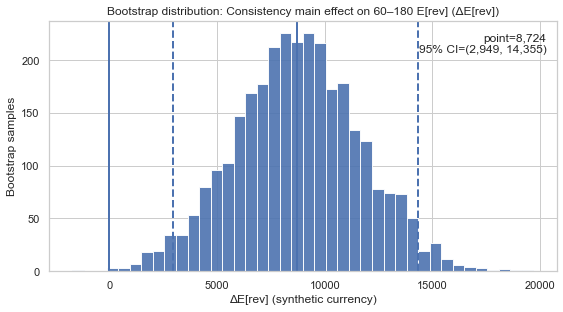

In [20]:
import matplotlib.pyplot as plt

# vals_total (bootstrap samples), point_total, ci_total

plt.figure(figsize=(8, 4.5))
plt.hist(vals_total, bins=40, alpha=0.9)

plt.axvline(0, linewidth=2)
plt.axvline(point_total, linewidth=2)
plt.axvline(ci_total[0], linestyle="--", linewidth=2)
plt.axvline(ci_total[1], linestyle="--", linewidth=2)

plt.title("Bootstrap distribution: Consistency main effect on 60–180 E[rev] (ΔE[rev])")
plt.xlabel("ΔE[rev] (synthetic currency)")
plt.ylabel("Bootstrap samples")

plt.text(
    0.98, 0.95,
    f"point={point_total:,.0f}\n95% CI=({ci_total[0]:,.0f}, {ci_total[1]:,.0f})",
    transform=plt.gca().transAxes,
    ha="right", va="top"
)

plt.tight_layout()

# save (add this line)
plt.savefig("figures(python)/fig01_ab_bootstrap_deltaErev_hist.png", dpi=180, bbox_inches="tight")

plt.show()


### Graph 2 — Main effects comparison (ΔE[rev], 60–180)

Activation/Consistency/Interaction의 main effect를 같은 기준(ΔE[rev])에서 비교한다.  
Consistency 효과가 가장 크고 신뢰구간도 양(+) 방향으로 유지되는 반면, Interaction은 0을 포함해 불확실성이 크다.


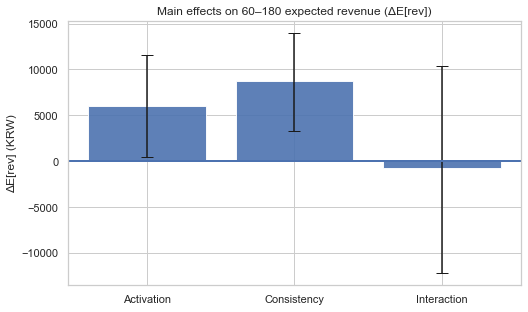

In [19]:
#Graph 2
labels = ["Activation", "Consistency", "Interaction"]
points = np.array([pt_A, pt_C, pt_I])
cis = np.array([ci_A, ci_C, ci_I])

yerr = np.vstack([points - cis[:, 0], cis[:, 1] - points])

plt.figure(figsize=(7.5, 4.5))```````````````````````````````a
plt.bar(labels, points, yerr=yerr, capsize=6, alpha=0.9)
plt.axhline(0, linewidth=2)
plt.title("Main effects on 60–180 expected revenue (ΔE[rev])")
plt.ylabel("ΔE[rev] (KRW)")
plt.tight_layout()

plt.savefig("figures(python)/fig02_ab_main_effects_deltaErev_bar.png", dpi=180, bbox_inches="tight")
plt.show()
